In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

In [2]:
# Reassigning columns to drop for ease of use & Reloading data for ease of use ()
df=pd.read_csv('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
df.columns = df.columns.str.strip()  # Remove leading and trailing spaces|

df_one_values = ['Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'CWE Flag Count',
 'Fwd Avg Bytes/Bulk',
 'Fwd Avg Packets/Bulk',
 'Fwd Avg Bulk Rate',
 'Bwd Avg Bytes/Bulk',
 'Bwd Avg Packets/Bulk',
 'Bwd Avg Bulk Rate']

columns_to_drop = ['Active Mean',
 'Active Min',
 'Average Packet Size',
 'Avg Bwd Segment Size',
 'Avg Fwd Segment Size',
 'Bwd Header Length',
 'Bwd IAT Max',
 'Bwd IAT Min',
 'Bwd IAT Std',
 'Bwd Packet Length Max',
 'Bwd Packet Length Mean',
 'Bwd Packet Length Std',
 'Flow Duration',
 'Flow IAT Max',
 'Flow IAT Mean',
 'Flow IAT Std',
 'Flow Packets/s',
 'Fwd IAT Max',
 'Fwd IAT Mean',
 'Fwd IAT Min',
 'Fwd IAT Std',
 'Fwd Packet Length Mean',
 'Fwd Packet Length Std',
 'Idle Max',
 'Idle Mean',
 'Idle Min',
 'Packet Length Mean',
 'Packet Length Std',
 'Packet Length Variance',
 'Subflow Bwd Bytes',
 'Subflow Bwd Packets',
 'Subflow Fwd Bytes',
 'Subflow Fwd Packets',
 'Total Backward Packets',
 'Total Fwd Packets',
 'Total Length of Bwd Packets',
 'Total Length of Fwd Packets',
 'act_data_pkt_fwd']

columns_to_drop_2 = ['Flow Bytes/s',
 'Flow IAT Min',
 'Fwd IAT Total',
 'Fwd Header Length',
 'Bwd Packets/s',
 'Init_Win_bytes_forward',
 'Active Std',
 'Active Max',
 'Idle Std']

# Tagging columns with the least information gain (Mostly due to close to zero variation in values)
columns_to_drop_3 = ['FIN Flag Count', 'RST Flag Count', 'ECE Flag Count']

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pickle

### Creating Model

1. Create a pipeline that preprocess previous analysis
2. Run a standardization preprocessing + PCA (explaining 95% variance of data) for numerical columns
3. Run one hot encoding for Protocol column, and select K Best for the whole categorical columns with chi square as its scoring method
4. Run gridsearch with Random Forest and Logistic Regression

In [4]:
df1_analyze = df.drop(columns=['Source Port', 'Destination Port', 'Destination IP', 'Source IP', 'Flow ID', 'Fwd Header Length.1', 'Timestamp'])

# Drop any rows with nulls
df1_analyze = df1_analyze.drop(index=df1_analyze[df1_analyze.isnull().any(axis=1)].index)

# Drop any rows with infinity
df1_analyze = df1_analyze.drop(index=df1_analyze[df1_analyze.isin([np.inf, -np.inf]).any(axis=1)].index)

# Dropping columns with only 1 value
df1_analyze = df1_analyze.drop(columns=df_one_values)

# Dropping columns with high colinearity
df1_analyze = df1_analyze.drop(columns=columns_to_drop)

# Dropping columns that have low correlation with target
df1_analyze = df1_analyze.drop(columns=columns_to_drop_2)

# Dropping columns that have low mutual information gain with target
df1_analyze = df1_analyze.drop(columns=columns_to_drop_3)

# Change flags to boolean type
to_bool = []
for x in df1_analyze.columns:
    if "Flag" in x:
        to_bool.append(x)
df1_analyze[to_bool] = df1_analyze[to_bool].astype('bool')

# Changing Label to 0 and 1
df1_analyze['Label'] = df1_analyze['Label'].apply(lambda x: 1 if x == "DDoS" else 0)
df1_analyze['Label'] = df1_analyze['Label'].astype('bool')

df1_analyze.shape

(225711, 18)

In [5]:
# Splitting data for training and testing
train_friday, test_friday = train_test_split(df1_analyze, test_size=0.3, random_state=42)

X_train_friday = train_friday.drop(columns='Label')
y_train_friday = train_friday['Label']
X_test_friday = test_friday.drop(columns='Label')
y_test_friday = test_friday['Label']

categorical_column = X_train_friday.select_dtypes('bool').columns
numerical_columns = X_train_friday.select_dtypes('number').columns

In [6]:
# Creating model pipeline
ohe = OneHotEncoder(handle_unknown="ignore")
pca = PCA(n_components=0.98)
selectk = SelectKBest(chi2, k=1)

numerical_pipeline = Pipeline([('standard_scaler', StandardScaler()), ('pca', pca)])

categorical_column_transformer = ColumnTransformer(
    [('one_hot_encoder', ohe, ['Protocol']),
     ('nothing', 'passthrough', categorical_column)]
)
categorical_pipeline = Pipeline([('cat_transformer', categorical_column_transformer), ('select_k', selectk)])

preprocessor = ColumnTransformer(
    [('cat_processing', categorical_pipeline, ['Protocol'] + list(categorical_column)),
     ('num_processing', numerical_pipeline, numerical_columns),]
)

#### Decision Tree

In [ ]:
# Creating model pipeline
estimator = DecisionTreeClassifier(random_state=42, min_samples_split=0.1)

param_random = {
    'preprocessing__cat_processing__select_k__k':range(3),
    'prediction__max_depth': range(1, 5),
    'prediction__min_samples_split': stats.uniform(0.1, 0.4)  
}

pipeline = Pipeline([('preprocessing', preprocessor), ('prediction', estimator)])

random_search = RandomizedSearchCV(pipeline, param_distributions=param_random, cv=5, scoring='accuracy', verbose=2, n_jobs=-1, random_state=42)

In [97]:
random_search.fit(X_train_friday,y_train_friday)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('cat_processing',
                                                                               Pipeline(steps=[('cat_transformer',
                                                                                                ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                                                                 OneHotEncoder(handle_unknown='ignore'),
                                                                                                                                 ['Protocol']),
                                                                                                                                ('nothing',
                                                                                                                                 'passthrough',
                                                                                                                                 Index(['Fwd PSH Flags', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'UR...
                                             ('prediction',
                                              DecisionTreeClassifier(min_samples_split=0.1,
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'prediction__max_depth': range(1, 5),
                                        'prediction__min_samples_split': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000250A327E8B0>,
                                        'preprocessing__cat_processing__select_k__k': range(0, 3)},
                   random_state=42, scoring='accuracy', verbose=2)

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

# 定义 DecisionTreeClassifier 估计器
estimator = DecisionTreeClassifier(random_state=42, min_samples_split=0.1)

# 定义参数网格
param_grid = {
    'preprocessing__cat_processing__select_k__k': list(range(3)),
    'prediction__max_depth': list(range(1, 5)),  # max_depth 从 1 到 4
    'prediction__min_samples_split': [0.1, 0.2, 0.3, 0.4]  # 离散的 min_samples_split 值
}

# 创建管道
pipeline = Pipeline([('preprocessing', preprocessor), ('prediction', estimator)])

# 设置 GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=0,  # 设置为0，不输出详细信息
    n_jobs=-1
)

# 拟合模型
grid_search.fit(X_train_friday, y_train_friday)

/home/ecs-user/is5126/final-project/.venv/lib/python3.10/site-packages/sklearn/feature_selection/_base.py:116: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
/home/ecs-user/is5126/final-project/.venv/lib/python3.10/site-packages/sklearn/feature_selection/_base.py:116: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
/home/ecs-user/is5126/final-project/.venv/lib/python3.10/site-packages/sklearn/feature_selection/_base.py:116: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
/home/ecs-user/is5126/final-project/.venv/lib/python3.10/site-packages/sklearn/feature_selection/_base.py:116: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
/home/ecs-user/is5126/final-project/.venv/lib/python3.10/site-packages/sklea

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('cat_processing',
                                                                         Pipeline(steps=[('cat_transformer',
                                                                                          ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                                                           OneHotEncoder(handle_unknown='ignore'),
                                                                                                                           ['Protocol']),
                                                                                                                          ('nothing',
                                                                                                                           'passthrough',
                                                                                                                           Index(['Fwd PSH Flags', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'URG Flag C...
       'Fwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Down/Up Ratio', 'Init_Win_bytes_backward', 'min_seg_size_forward'],
      dtype='object'))])),
                                       ('prediction',
                                        DecisionTreeClassifier(min_samples_split=0.1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'prediction__max_depth': [1, 2, 3, 4],
                         'prediction__min_samples_split': [0.1, 0.2, 0.3, 0.4],
                         'preprocessing__cat_processing__select_k__k': [0, 1,
                                                                        2]},
             scoring='accuracy')

In [98]:
random_search.best_params_

{'prediction__max_depth': 4,
 'prediction__min_samples_split': 0.1571467271687763,
 'preprocessing__cat_processing__select_k__k': 2}

In [8]:
grid_search.best_params_

{'prediction__max_depth': 4,
 'prediction__min_samples_split': 0.1,
 'preprocessing__cat_processing__select_k__k': 0}

              precision    recall  f1-score   support

       False       1.00      0.98      0.99     29321
        True       0.99      1.00      0.99     38393

    accuracy                           0.99     67714
   macro avg       0.99      0.99      0.99     67714
weighted avg       0.99      0.99      0.99     67714



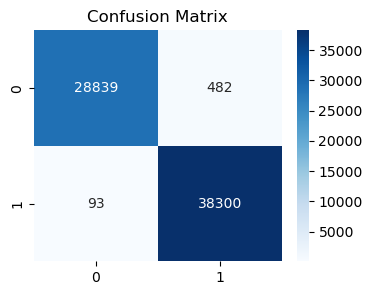

In [100]:
prediction = random_search.best_estimator_.predict(X_test_friday)
print(classification_report(y_test_friday, prediction))
conf_mat = confusion_matrix(y_test_friday, prediction)
plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
plt.title('Confusion Matrix')
plt.show()

/home/ecs-user/is5126/final-project/.venv/lib/python3.10/site-packages/sklearn/feature_selection/_base.py:116: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


              precision    recall  f1-score   support

       False       1.00      0.98      0.99     29321
        True       0.99      1.00      0.99     38393

    accuracy                           0.99     67714
   macro avg       0.99      0.99      0.99     67714
weighted avg       0.99      0.99      0.99     67714



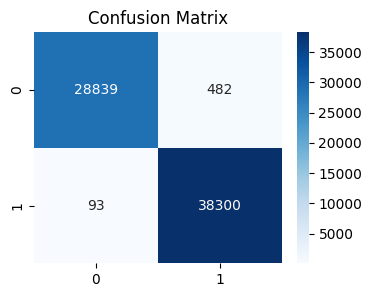

In [9]:
prediction = grid_search.best_estimator_.predict(X_test_friday)
print(classification_report(y_test_friday, prediction))
conf_mat = confusion_matrix(y_test_friday, prediction)
plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
plt.title('Confusion Matrix')
plt.show()

In [101]:
with open('model_1_dt_randomsearch.pkl', 'wb') as file:
    pickle.dump(random_search, file)

In [10]:
with open('model_1_dt_gridsearch.pkl', 'wb') as file:
    pickle.dump(grid_search, file)

### SVC Model

In [18]:
estimator = SVC(kernel='linear',gamma=10, C=100)

param_random= {
    'preprocessing__cat_processing__select_k__k':range(3),
    'prediction__kernel': ['linear', 'poly', 'rbf'],
    'prediction__gamma': stats.loguniform(0.1, 100),
    'prediction__C': stats.loguniform(1e-3, 1e2)
}

pipeline = Pipeline([('preprocessing', preprocessor), ('prediction', estimator)])

random_search = RandomizedSearchCV(pipeline, param_distributions=param_random, cv=5, scoring='accuracy', verbose=2, n_jobs=-1, random_state=42)

In [19]:
pipeline.fit(X_train_friday,y_train_friday)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat_processing',
                                                  Pipeline(steps=[('cat_transformer',
                                                                   ColumnTransformer(transformers=[('one_hot_encoder',
                                                                                                    OneHotEncoder(handle_unknown='ignore'),
                                                                                                    ['Protocol']),
                                                                                                   ('nothing',
                                                                                                    'passthrough',
                                                                                                    Index(['Fwd PSH Flags', 'SYN Flag Count', 'PSH Flag Count', 'ACK Flag Count',
       'URG Flag Count'],
      dtype='object'))])),
                                                                  (...
                                                  Pipeline(steps=[('standard_scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.98))]),
                                                  Index(['Protocol', 'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Bwd Packet Length Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Fwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Down/Up Ratio', 'Init_Win_bytes_backward', 'min_seg_size_forward'],
      dtype='object'))])),
                ('prediction', SVC(C=100, gamma=10, kernel='linear'))])

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import numpy as np

import warnings
warnings.filterwarnings("ignore")


# 定义 SVC 估计器
estimator = SVC(kernel='linear', gamma=10, C=100)

# 定义参数网格
param_grid = {
    'preprocessing__cat_processing__select_k__k': list(range(3)),
    'prediction__kernel': ['linear', 'poly', 'rbf'],
    'prediction__gamma': [0.1, 1, 10, 100],  # 离散的 gamma 值
    'prediction__C': [0.001, 0.01, 0.1, 1, 10, 100]  # 离散的 C 值
}

# 创建管道
pipeline = Pipeline([('preprocessing', preprocessor), ('prediction', estimator)])

# 设置 GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=0,  # 设置为 0，静默输出
    n_jobs=-1
)

# 拟合模型
grid_search.fit(X_train_friday, y_train_friday)

/home/ecs-user/is5126/final-project/.venv/lib/python3.10/site-packages/sklearn/feature_selection/_base.py:116: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
/home/ecs-user/is5126/final-project/.venv/lib/python3.10/site-packages/sklearn/feature_selection/_base.py:116: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
/home/ecs-user/is5126/final-project/.venv/lib/python3.10/site-packages/sklearn/feature_selection/_base.py:116: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
/home/ecs-user/is5126/final-project/.venv/lib/python3.10/site-packages/sklearn/feature_selection/_base.py:116: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
/home/ecs-user/is5126/final-project/.venv/lib/python3.10/site-packages/sklea

In [ ]:
random_search.best_params_

{'prediction__C': 7.915074397656213,
 'prediction__l1_ratio': 0.6371651421518383,
 'preprocessing__cat_processing__select_k__k': 1}

In [ ]:
grid_search.best_params_

              precision    recall  f1-score   support

       False       1.00      0.98      0.99     29321
        True       0.98      1.00      0.99     38393

    accuracy                           0.99     67714
   macro avg       0.99      0.99      0.99     67714
weighted avg       0.99      0.99      0.99     67714



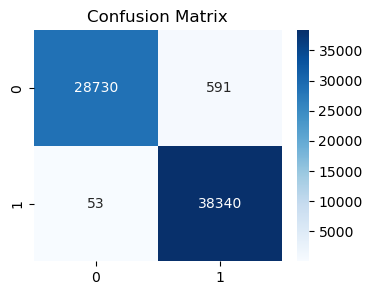

In [20]:
# prediction = random_search.best_estimator_.predict(X_test_friday)
prediction = pipeline.predict(X_test_friday)
print(classification_report(y_test_friday, prediction))
conf_mat = confusion_matrix(y_test_friday, prediction)
plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
with open('model_1_svc_randomsearch.pkl', 'wb') as file:
    pickle.dump(random_search, file)

# Testing the model on another dataset (CIC 2019)

In [ ]:
# Reading the file
cic_df=pd.read_csv('cicddos2019_dataset.csv', index_col=0)

# Renaming columns to match the model
rename_column =  {'Packet Length Max': 'Max Packet Length',
                  'Init Fwd Win Bytes':'Init_Win_bytes_forward',
                  'Bwd Packets Length Total':'Total Length of Bwd Packets',
                  'Packet Length Min':'Min Packet Length',
                  'Fwd Seg Size Min':'min_seg_size_forward',
                  'Fwd Act Data Packets':'act_data_pkt_fwd',
                  'Avg Packet Size':'Average Packet Size',
                  'Init Bwd Win Bytes':'Init_Win_bytes_backward',
                  'Fwd Packets Length Total':'Total Length of Fwd Packets'
                }
cic_df = cic_df.rename(columns=rename_column)
cic_df.head()

In [12]:
# Drop any rows with nulls
cic_df = cic_df.drop(index=cic_df[cic_df.isnull().any(axis=1)].index)

# Drop any rows with infinity
cic_df = cic_df.drop(index=cic_df[cic_df.isin([np.inf, -np.inf]).any(axis=1)].index)

# Change flags to boolean type
to_bool = []
for x in cic_df.columns:
    if "Flag" in x:
        to_bool.append(x)
cic_df[to_bool] = cic_df[to_bool].astype('bool')

# Changing Label to 0 and 1
cic_df['Label'] = cic_df['Label'].apply(lambda x: 0 if x == "Benign" else 1)
cic_df['Label'] = cic_df['Label'].astype('bool')

# Separating features from target
X_cic = cic_df.drop(columns=['Label','Class'])
y_cic = cic_df['Label']

#### Decision Tree Model

              precision    recall  f1-score   support

       False       0.24      0.99      0.38     97831
        True       0.97      0.06      0.11    333540

    accuracy                           0.27    431371
   macro avg       0.60      0.53      0.25    431371
weighted avg       0.80      0.27      0.17    431371



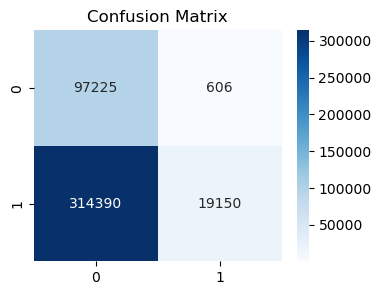

In [54]:
with open('model_1_dt_randomsearch.pkl', 'rb') as file:
    loaded_model_pickle = pickle.load(file)

prediction_cic = loaded_model_pickle.best_estimator_.predict(X_cic)
print(classification_report(y_cic, prediction_cic))
conf_mat = confusion_matrix(y_cic, prediction_cic)
plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
plt.title('Confusion Matrix')
plt.show()

#### Logistic Regression Model

              precision    recall  f1-score   support

       False       0.41      0.97      0.58     97831
        True       0.98      0.60      0.74    333540

    accuracy                           0.68    431371
   macro avg       0.70      0.78      0.66    431371
weighted avg       0.85      0.68      0.71    431371



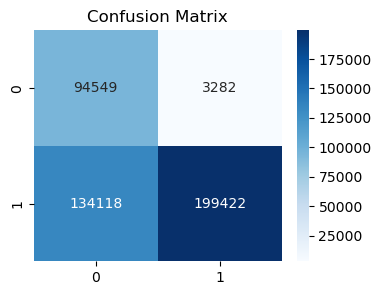

In [51]:
with open('model_1_logreg_randomsearch.pkl', 'rb') as file:
    loaded_model_pickle = pickle.load(file)

prediction_cic = loaded_model_pickle.best_estimator_.predict(X_cic)
print(classification_report(y_cic, prediction_cic))
conf_mat = confusion_matrix(y_cic, prediction_cic)
plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
with open('model_1_logreg_gridsearch.pkl', 'rb') as file:
    loaded_model_pickle = pickle.load(file)

# prediction_cic = loaded_model_pickle.best_estimator_.predict(X_cic)
# print(classification_report(y_cic, prediction_cic))
# conf_mat = confusion_matrix(y_cic, prediction_cic)
# plt.figure(figsize=(4,3))
# sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
# plt.title('Confusion Matrix')
# plt.show()

In [34]:
loaded_model_pickle.best_params_

{'prediction__C': 7.915074397656213,
 'prediction__l1_ratio': 0.6371651421518383,
 'preprocessing__cat_processing__select_k__k': 1}

#### XGBoost Tree

              precision    recall  f1-score   support

       False       0.24      1.00      0.38     97831
        True       0.98      0.06      0.10    333540

    accuracy                           0.27    431371
   macro avg       0.61      0.53      0.24    431371
weighted avg       0.81      0.27      0.17    431371



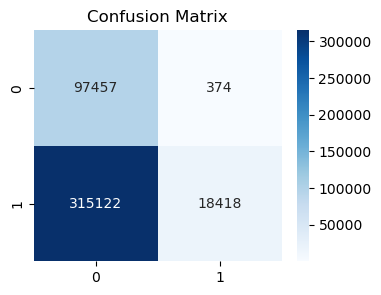

In [52]:
with open('model_1_xgb_randomsearch.pkl', 'rb') as file:
    loaded_model_pickle = pickle.load(file)

prediction_cic = loaded_model_pickle.best_estimator_.predict(X_cic)
print(classification_report(y_cic, prediction_cic))
conf_mat = confusion_matrix(y_cic, prediction_cic)
plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
plt.title('Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

       False       0.24      1.00      0.38     97831
        True       0.98      0.06      0.10    333540

    accuracy                           0.27    431371
   macro avg       0.61      0.53      0.24    431371
weighted avg       0.81      0.27      0.17    431371



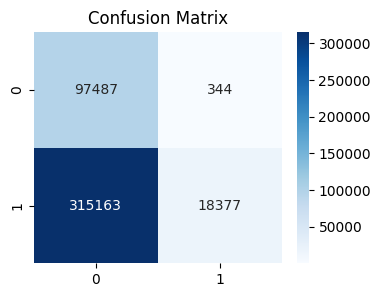

[CV] END prediction__gamma=0.01, prediction__learning_rate=0.001, prediction__max_depth=6, preprocessing__cat_processing__select_k__k=3; total time=   1.3s
[CV] END prediction__gamma=0.01, prediction__learning_rate=0.001, prediction__max_depth=12, preprocessing__cat_processing__select_k__k=0; total time=   1.6s
[CV] END prediction__gamma=0.01, prediction__learning_rate=0.001, prediction__max_depth=16, preprocessing__cat_processing__select_k__k=3; total time=   1.8s
[CV] END prediction__gamma=0.01, prediction__learning_rate=0.01, prediction__max_depth=2, preprocessing__cat_processing__select_k__k=1; total time=   1.1s
[CV] END prediction__gamma=0.01, prediction__learning_rate=0.01, prediction__max_depth=6, preprocessing__cat_processing__select_k__k=0; total time=   1.3s
[CV] END prediction__gamma=0.01, prediction__learning_rate=0.01, prediction__max_depth=10, preprocessing__cat_processing__select_k__k=3; total time=   1.6s
[CV] END prediction__gamma=0.01, prediction__learning_rate=0.01,

In [29]:
with open('model_1_xgb_gridsearch.pkl', 'rb') as file:
    loaded_model_pickle = pickle.load(file)

prediction_cic = loaded_model_pickle.best_estimator_.predict(X_cic)
print(classification_report(y_cic, prediction_cic))
conf_mat = confusion_matrix(y_cic, prediction_cic)
plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
plt.title('Confusion Matrix')
plt.show()

c:\anaconda\envs\deeplearning\lib\site-packages\sklearn\feature_selection\_base.py:102: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


              precision    recall  f1-score   support

       False       0.22      0.81      0.34     97831
        True       0.72      0.15      0.25    333540

    accuracy                           0.30    431371
   macro avg       0.47      0.48      0.29    431371
weighted avg       0.61      0.30      0.27    431371



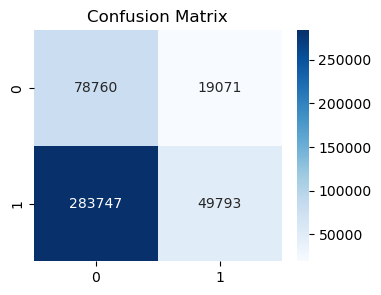

In [84]:
with open('model_1_xgblinear_randomsearch.pkl', 'rb') as file:
    loaded_model_pickle = pickle.load(file)

prediction_cic = loaded_model_pickle.best_estimator_.predict(X_cic)
print(classification_report(y_cic, prediction_cic))
conf_mat = confusion_matrix(y_cic, prediction_cic)
plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
plt.title('Confusion Matrix')
plt.show()

              precision    recall  f1-score   support

       False       0.35      0.95      0.51     97831
        True       0.97      0.48      0.64    333540

    accuracy                           0.58    431371
   macro avg       0.66      0.71      0.57    431371
weighted avg       0.83      0.58      0.61    431371



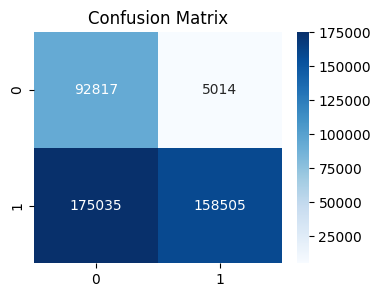

[CV] END prediction__learning_rate=0.01, prediction__reg_alpha=0.1, prediction__reg_lambda=0.0001, preprocessing__cat_processing__select_k__k=7; total time=   1.9s
[CV] END prediction__learning_rate=0.01, prediction__reg_alpha=0.1, prediction__reg_lambda=0.1, preprocessing__cat_processing__select_k__k=0; total time=   1.4s
[CV] END prediction__learning_rate=0.01, prediction__reg_alpha=0.1, prediction__reg_lambda=1.0, preprocessing__cat_processing__select_k__k=0; total time=   1.4s
[CV] END prediction__learning_rate=0.01, prediction__reg_alpha=1.0, prediction__reg_lambda=1e-08, preprocessing__cat_processing__select_k__k=1; total time=   1.3s
[CV] END prediction__learning_rate=0.01, prediction__reg_alpha=1.0, prediction__reg_lambda=0.0001, preprocessing__cat_processing__select_k__k=1; total time=   1.3s
[CV] END prediction__learning_rate=0.01, prediction__reg_alpha=1.0, prediction__reg_lambda=0.01, preprocessing__cat_processing__select_k__k=3; total time=   1.4s
[CV] END prediction__lear

In [22]:
with open('model_1_xgblinear_gridsearch.pkl', 'rb') as file:
    loaded_model_pickle = pickle.load(file)

prediction_cic = loaded_model_pickle.best_estimator_.predict(X_cic)
print(classification_report(y_cic, prediction_cic))
conf_mat = confusion_matrix(y_cic, prediction_cic)
plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
plt.title('Confusion Matrix')
plt.show()